# Exploratory Data Analysis and Various Regressions

### Import relevant libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.linear_model import LinearRegression, Lasso, SGDRegressor
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy.stats as stats
import seaborn as sns
import itertools
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor

%matplotlib inline

/Users/samfunk/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Import pickled `master` dataframe

In [2]:
with open('/Users/samfunk/ds/metis/project_luther/master.pkl', 'rb') as f:
    master = pickle.load(f)

## Feature engineering

In [3]:
master['ss_econ_sq'] = master['ss_econ']**2
master['ss_day_sq'] = master['ss_day']**2
master['weighted_sq'] = master['weighted']**2
master['releases_sq'] = master['releases']**2

master['ss_econ_log'] = master['ss_econ'].apply(lambda x: np.log(x))
master['weighted_log'] = master['weighted'].apply(lambda x: np.log(x))
master['ss_day_log'] = master['ss_day'].apply(lambda x: np.log(x))

master['ss_econ_sqrt'] = master['ss_econ']**0.5
master['ss_day_sqrt'] = master['ss_day']**0.5
master['weighted_sqrt'] = master['weighted']**0.5
master['releases_sqrt'] = master['releases']**0.5

### Create `feature_set1` dataframe

In [4]:
feature_set1 = master.loc[:, 'ss_econ_sq':]
cols = master.loc[:, ['ss_day', 'ss_econ', 'releases', 'weighted']]
feature_set1 = feature_set1.join(cols, how='left')
feature_set1 = feature_set1.join(master.spx_lag, how='right')
feature_set1 = feature_set1.join(master.abs_lag, how='right')

### Relevant features

In [5]:
features = ['ss_day', 'ss_econ', 'weighted', 'releases', 'ss_econ_sq', 'ss_day_sq', 'weighted_sq', 'releases_sq', 'ss_econ_log', 'ss_day_log', 'weighted_log', 'ss_econ_sqrt', 'ss_day_sqrt', 'weighted_sqrt', 'releases_sqrt']

# Regressions

### Shuffle data

In [6]:
np.random.seed(42)
shuffle = feature_set1.sample(frac=1)

## Basic Linear Regression with Cross Validation

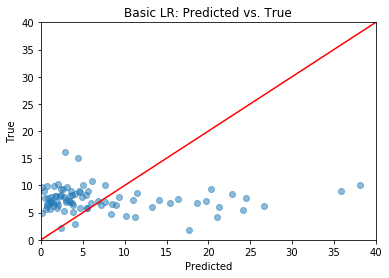

In [7]:
X = np.array(shuffle.loc[:, ['ss_econ', 'ss_day', 'releases', 'weighted']])
y = np.array(shuffle.loc[:, ['abs_lag']])
X_ones = np.c_[np.ones(X.shape[0]), X]
lr = LinearRegression()
scores = cross_val_score(lr, X_ones, y, cv=10, scoring=make_scorer(mean_squared_error))
y_pred = cross_val_predict(lr, X_ones, y, cv=10)

plt.scatter(y, y_pred, alpha=0.5)
plt.plot([0,40], [0,40], 'r-')
plt.xlim(0,40)
plt.ylim(0,40)
plt.ylabel('True')
plt.xlabel('Predicted')
plt.title('Basic LR: Predicted vs. True');

In [8]:
print(scores, np.mean(scores))

[  56.04107448   82.76441711   47.32146729   21.42369874  242.73823198
   33.56719839  165.39286896   21.19032057   18.50869923   50.15539364] 73.910337039


## Stochastic Gradient Descent

In [9]:
X = np.array(shuffle.loc[:, ['ss_econ', 'ss_day', 'releases', 'weighted']])
y = np.array(shuffle.loc[:, 'abs_lag'])
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=.2)

ss = StandardScaler()
ss.fit(X_train)
X_train_std = ss.transform(X_train)
X_test_std = ss.transform(X_test)


ssX = StandardScaler()
ssX.fit(X)
X_std = ss.transform(X)

### Model

In [10]:
model = SGDRegressor(max_iter=5000, learning_rate='constant')
parameters = {'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1], 'fit_intercept': [True, False]}
grid = GridSearchCV(model, parameters, cv=5, scoring='neg_mean_absolute_error', n_jobs=1)
grid.fit(X_std, y)
grid.cv_results_

{'mean_fit_time': array([ 0.01762929,  0.01216135,  0.01158171,  0.01155677,  0.01298866,
         0.01134591,  0.01181059,  0.01151433,  0.0125248 ,  0.01135969]),
 'mean_score_time': array([ 0.00033002,  0.0001524 ,  0.00016131,  0.00015564,  0.00014739,
         0.00012789,  0.00013604,  0.00012956,  0.0001658 ,  0.00012975]),
 'mean_test_score': array([-6.72592315, -7.83596975, -6.81450357, -7.84707404, -6.8116834 ,
        -7.83889736, -6.70214208, -7.78828524, -6.68840687, -7.67311882]),
 'mean_train_score': array([-6.00748534, -7.3947751 , -6.01104787, -7.40217152, -6.00912808,
        -7.41226977, -6.03237886, -7.38394503, -5.97864812, -7.37347429]),
 'param_alpha': masked_array(data = [1e-05 1e-05 0.0001 0.0001 0.001 0.001 0.01 0.01 0.1 0.1],
              mask = [False False False False False False False False False False],
        fill_value = ?),
 'param_fit_intercept': masked_array(data = [True False True False True False True False True False],
              mask = [False

In [11]:
best_sgd = grid.best_estimator_
sgd_pred = best_sgd.predict(X_std)
error = 0
pred_resid = []
for true, pred in zip(y, sgd_pred):
    resid = true - pred
    error += resid**2
    pred_resid.append('pred: {}, resid: {}'.format(str(pred), str(resid)))
mse = error / len(sgd_pred)
print('MSE: {}'.format(mse))

MSE: 62.88472741741068


### Plot SGD prediction vs. true

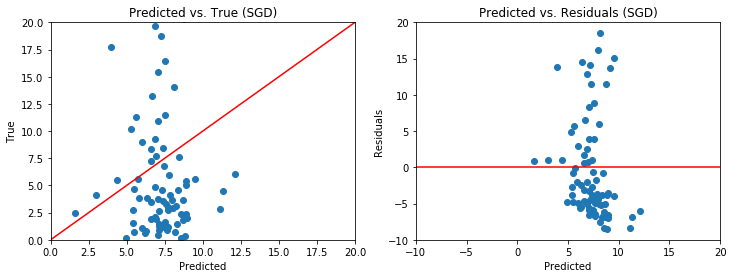

In [12]:
fig, ax = plt.subplots(1,2,figsize=(12,4))

ax[0].scatter(sgd_pred.reshape(-1,1), y)
ax[0].plot([0,20],[0,20], 'r-')
ax[0].set_xlim(0,20)
ax[0].set_ylim(0,20)
ax[0].set_ylabel('True')
ax[0].set_xlabel('Predicted')
ax[0].set_title('Predicted vs. True (SGD)');

ax[1].scatter(sgd_pred.reshape(-1,1), (y - sgd_pred).reshape(-1,1))
ax[1].plot([-10,20],[0,0], 'r-')
ax[1].set_xlim(-10,20)
ax[1].set_ylim(-10,20)
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('Residuals')
ax[1].set_title('Predicted vs. Residuals (SGD)');

## Lasso regularization

NOTE: The initial lasso modeling removed the `ss_econ` variable (made its coefficient 0), however, for some reason, this version of the modeling continues to include it. As we will see throughout the next two models, the first, of which does not train/test split the data, performs slightly better. To test this model, we would need to gather additional feature and target data to determine the predicted vs. true results, and, thus, the effectiveness of the model.

### Select features and variables

In [13]:
X = np.array(shuffle.loc[:, ['ss_econ', 'ss_day', 'releases', 'weighted']])
y = np.array(shuffle.loc[:, 'abs_lag'])

### Standardize unsplit data

In [14]:
ssX = StandardScaler()
ssX.fit(X)
X_std = ss.transform(X)

## Linear Regression with Lasso regularization on unsplit data

In [15]:
model = Lasso(max_iter=5000)
parameters = {'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1], 'fit_intercept': [True, False]}
grid = GridSearchCV(model, parameters, cv=5, scoring='neg_mean_absolute_error', n_jobs=1)
grid.fit(X_std, y)
grid.cv_results_

{'mean_fit_time': array([ 0.00050735,  0.00022535,  0.00032721,  0.00041647,  0.00042167,
         0.00050254,  0.00043139,  0.00042772,  0.00029721,  0.00022106]),
 'mean_score_time': array([ 0.00020738,  0.00012684,  0.00017962,  0.00024471,  0.00020494,
         0.0006114 ,  0.00019708,  0.00021482,  0.00013466,  0.00014043]),
 'mean_test_score': array([-6.80788628, -7.82736661, -6.80783506, -7.82726941, -6.80732808,
        -7.8263101 , -6.80242771, -7.81672648, -6.74502283, -7.72196044]),
 'mean_train_score': array([-6.00566902, -7.394064  , -6.00564192, -7.39402199, -6.00536477,
        -7.39357528, -6.00260549, -7.38911574, -5.98676714, -7.34985101]),
 'param_alpha': masked_array(data = [1e-05 1e-05 0.0001 0.0001 0.001 0.001 0.01 0.01 0.1 0.1],
              mask = [False False False False False False False False False False],
        fill_value = ?),
 'param_fit_intercept': masked_array(data = [True False True False True False True False True False],
              mask = [False

In [16]:
grid.best_estimator_.coef_

array([ 1.05833804, -0.51818096,  1.17588029, -0.66138331])

In [17]:
grid.best_estimator_.score(X_std, y)

0.044951816185540783

### Best model

In [18]:
best_lasso = grid.best_estimator_
lasso_pred = best_lasso.predict(X_std)
pred_resid = []
error = 0
for true, pred in zip(y, lasso_pred):
    resid = true - pred
    error += resid**2
    pred_resid.append('pred: {}, resid: {}'.format(str(pred), str(resid)))
mse = error / len(lasso_pred)
mse

62.50580240071244

### Plot results

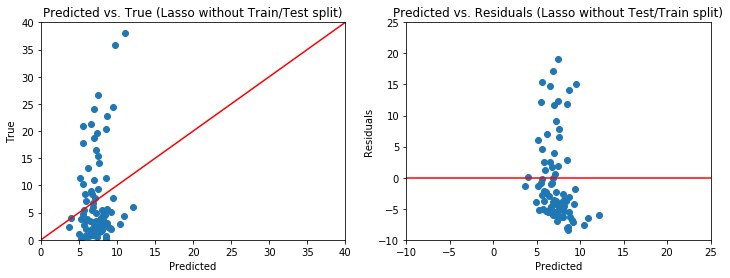

In [19]:
fig, ax = plt.subplots(1,2,figsize=(12,4))

ax[0].scatter(lasso_pred.reshape(-1,1), y)
ax[0].plot([0,40], [0,40], 'r-')
ax[0].set_xlim(0,40)
ax[0].set_ylim(0,40)
ax[0].set_ylabel('True')
ax[0].set_xlabel('Predicted')
ax[0].set_title('Predicted vs. True (Lasso without Train/Test split)');

ax[1].scatter(lasso_pred.reshape(-1,1), (y - lasso_pred).reshape(-1,1))
ax[1].plot([-10,25],[0,0], 'r-')
ax[1].set_xlim(-10,25)
ax[1].set_ylim(-10,25)
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('Residuals')
ax[1].set_title('Predicted vs. Residuals (Lasso without Test/Train split)');

## Linear Regression with Lasso regularization on train/test split data

This model performs much worse than the one above. This is due to the fact there is not enough data to properly train/test split. I included it as practice/demo.

### Standardize features (80:20 train/test split)

In [20]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=.2)
ss = StandardScaler()
ss.fit(X_train)
X_train_std = ss.transform(X_train)
X_test_std = ss.transform(X_test)

### Model

In [21]:
model = Lasso(max_iter=5000)
parameters = {'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1], 'fit_intercept': [True, False]}
grid = GridSearchCV(model, parameters, cv=5, scoring=make_scorer(mean_squared_error), n_jobs=1)
grid.fit(X_train_std, Y_train)
grid.cv_results_

{'mean_fit_time': array([ 0.00037537,  0.00023823,  0.0002912 ,  0.00043087,  0.00054822,
         0.0003458 ,  0.0004468 ,  0.00031686,  0.00032997,  0.00023532]),
 'mean_score_time': array([ 0.00014901,  0.0001368 ,  0.00014734,  0.00023031,  0.00024099,
         0.00019016,  0.0002284 ,  0.00016079,  0.00014763,  0.00012536]),
 'mean_test_score': array([  77.7516804 ,  134.68344374,   77.75118189,  134.68309762,
          77.74621195,  134.67964592,   77.6979516 ,  134.64664455,
          77.3620925 ,  134.4576257 ]),
 'mean_train_score': array([  62.29496125,  119.98970972,   62.29496137,  119.98970983,
          62.29497283,  119.98972126,   62.29611777,  119.9908636 ,
          62.40984814,  120.10424065]),
 'param_alpha': masked_array(data = [1e-05 1e-05 0.0001 0.0001 0.001 0.001 0.01 0.01 0.1 0.1],
              mask = [False False False False False False False False False False],
        fill_value = ?),
 'param_fit_intercept': masked_array(data = [True False True False True F

In [22]:
print('coefficients: {}'.format(grid.best_estimator_.coef_))
print('intercept: {}'.format(grid.best_estimator_.intercept_))

coefficients: [ 3.24578184 -2.34849138  1.55165946 -1.15868994]
intercept: 0.0


### Best model

In [23]:
best_lasso = grid.best_estimator_
lasso_pred = best_lasso.predict(X_test_std)
error = 0
for true, pred in zip(Y_test, lasso_pred):
    resid = true - pred
    error += resid**2
    print('pred, resid:', str(pred) + ', $' + str(resid))
mse = error / len(lasso_pred)
print('MSE: {}'.format(mse))

pred, resid: -1.95040872496, $4.01046772496
pred, resid: -4.21627018491, $8.01631918491
pred, resid: 0.809002172758, $25.8711728272
pred, resid: -7.53519327102, $9.96536927102
pred, resid: 0.697061909716, $1.10298709028
pred, resid: 1.430581426, $1.199545574
pred, resid: 1.23245851765, $2.43770748235
pred, resid: 2.95632010484, $0.683816895156
pred, resid: 8.04221580875, $-3.58225480875
pred, resid: -3.24994958883, $12.2599585888
pred, resid: 0.0288499259975, $6.741170074
pred, resid: -1.63752754303, $8.85749854303
pred, resid: 3.6268782227, $-1.3768782227
pred, resid: 0.857205515511, $4.55295048449
pred, resid: 1.76594777642, $-0.346025776421
pred, resid: 9.36175863313, $-6.54169063313
pred, resid: -0.993317308096, $19.6932683081
MSE: 94.02577137298078


### Plot Predicted vs. True (Train/Test)

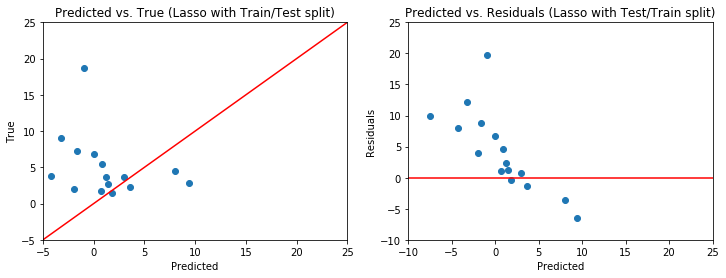

In [24]:
fig, ax = plt.subplots(1,2,figsize=(12,4))

ax[0].scatter(lasso_pred.reshape(-1,1), Y_test)
ax[0].plot([-5,25],[-5,25], 'r-')
ax[0].set_xlim(-5,25)
ax[0].set_ylim(-5,25)
ax[0].set_ylabel('True')
ax[0].set_xlabel('Predicted')
ax[0].set_title('Predicted vs. True (Lasso with Train/Test split)');

ax[1].scatter(lasso_pred.reshape(-1,1), (Y_test - lasso_pred).reshape(-1,1))
ax[1].plot([-10,25],[0,0], 'r-')
ax[1].set_xlim(-10,25)
ax[1].set_ylim(-10,25)
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('Residuals')
ax[1].set_title('Predicted vs. Residuals (Lasso with Test/Train split)');

## Correlation pairplots for different datasets vs. SPX

In [25]:
cal = master.loc[:, ['fomc', 'releases', 'speeches', 'abs_lag']]
google = master.loc[:, ['weighted', 'trend_lag1', 'abs_lag', 'spx_lag']]
mw = master.loc[:, ['strong_day', 'strong_soft', 'ss_day', 'strong_econ', 'ss_econ', 'squared', 'spx_lag', 'abs_lag']]

### Main features correlations

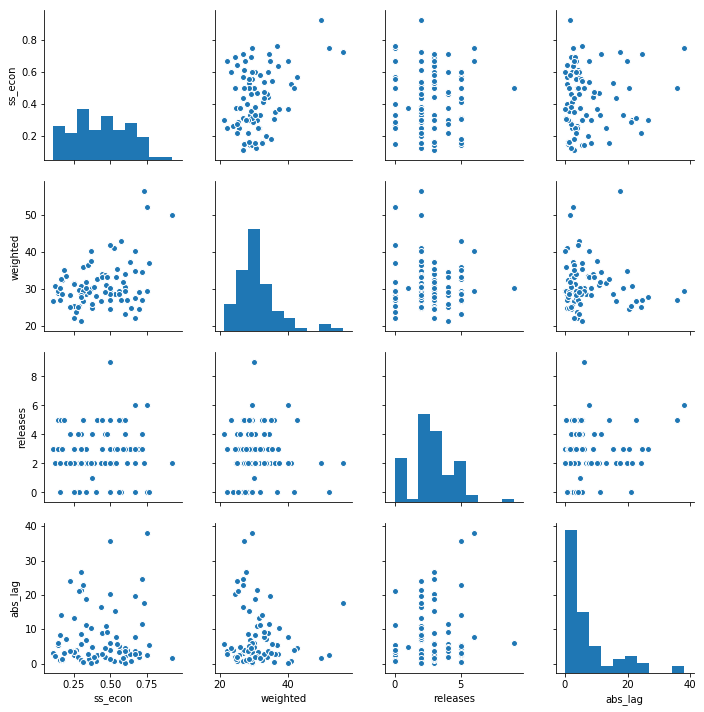

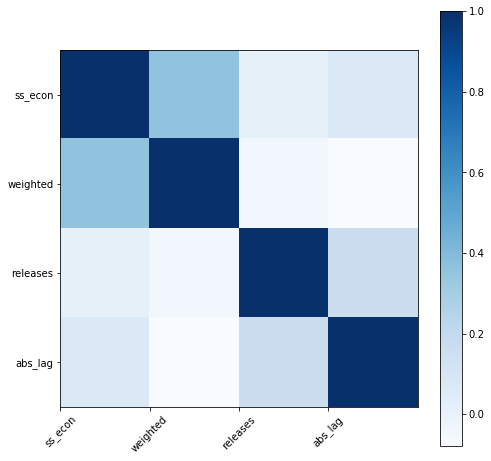

In [26]:
test = master.loc[:, ['ss_econ', 'weighted', 'releases', 'abs_lag']]
sns.pairplot(test)
corr = test.corr()
plt.figure(figsize=(8,8))
ax = plt.gca()
plt.imshow(corr, cmap='Blues', interpolation='nearest')
cbar = plt.colorbar()
plt.grid(False)
plt.yticks(np.arange(corr.shape[1]))
plt.xticks(np.arange(corr.shape[0])-0.5, rotation=45)
ax.set_xticklabels(list(test.columns), minor=False)
ax.set_yticklabels(list(test.columns), minor=False);

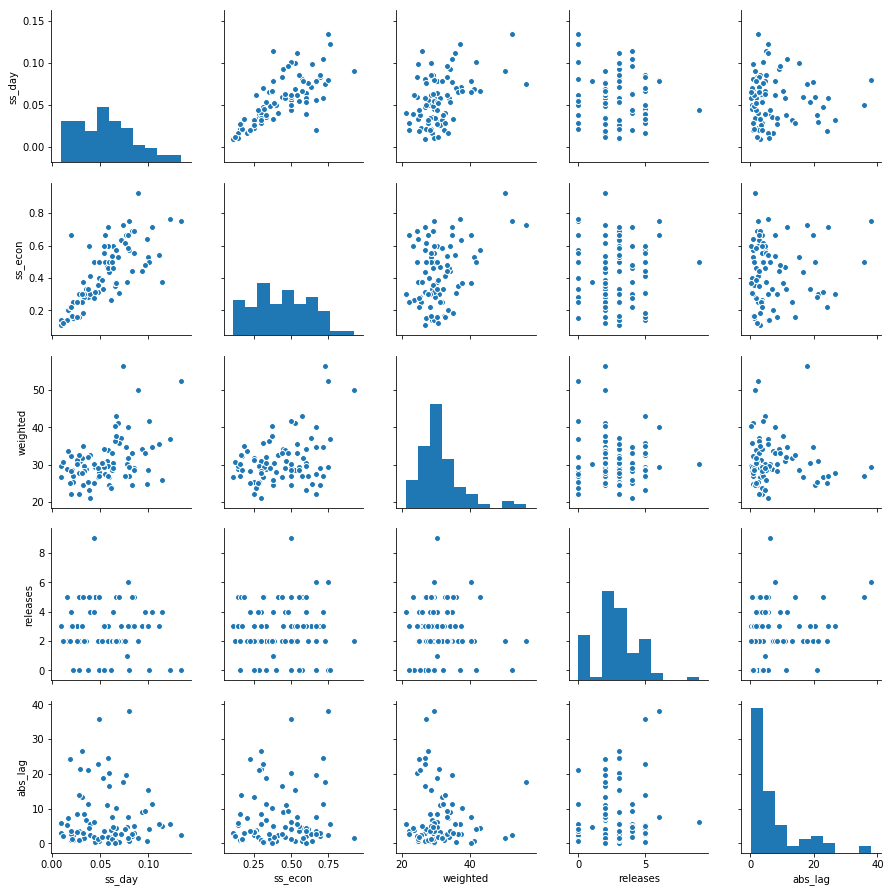

In [27]:
sns.pairplot(feature_set1.loc[:, ['ss_day', 'ss_econ', 'weighted', 'releases', 'abs_lag']]);

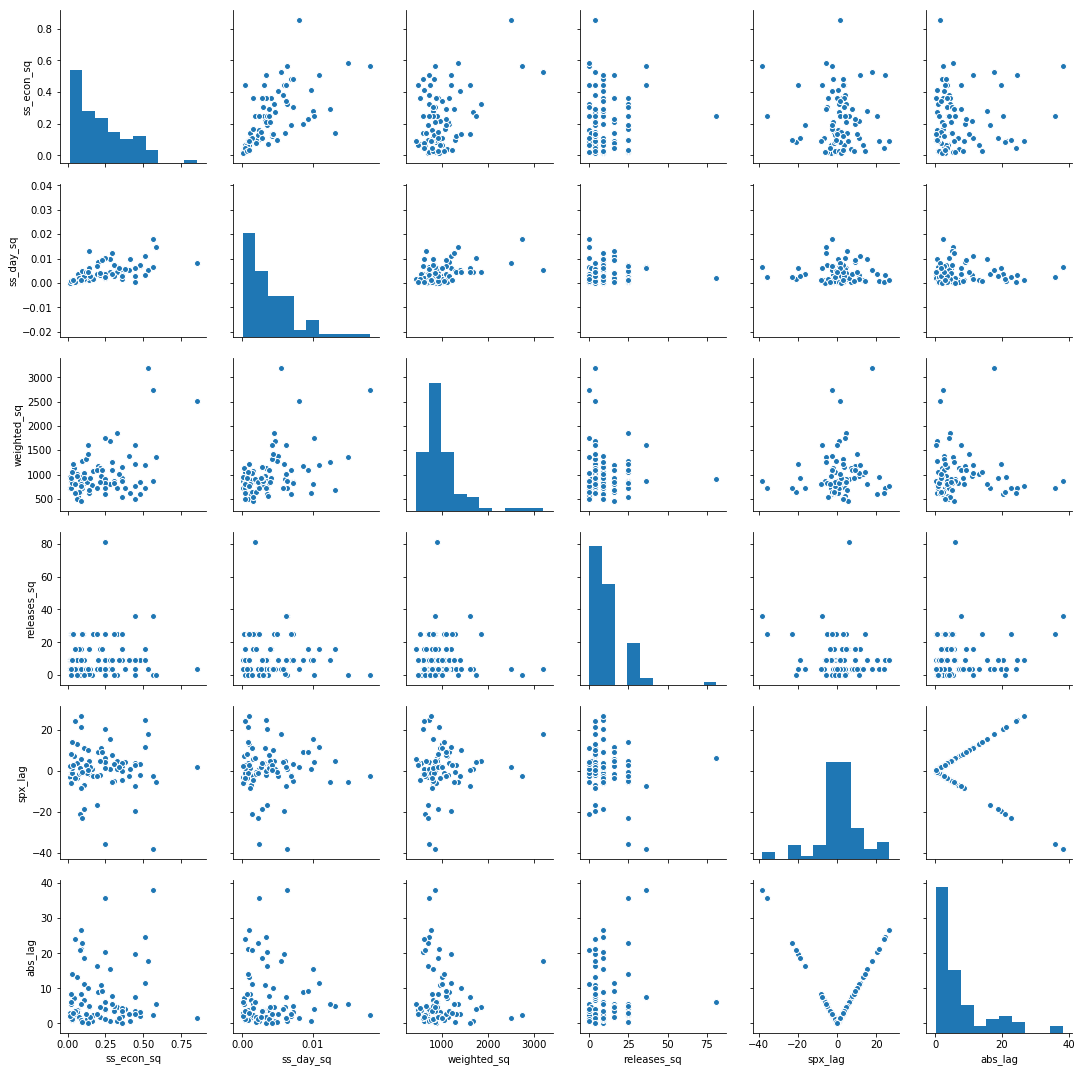

In [28]:
sns.pairplot(feature_set1.loc[:, ['ss_econ_sq', 'ss_day_sq', 'weighted_sq', 'releases_sq', 'spx_lag', 'abs_lag']]);

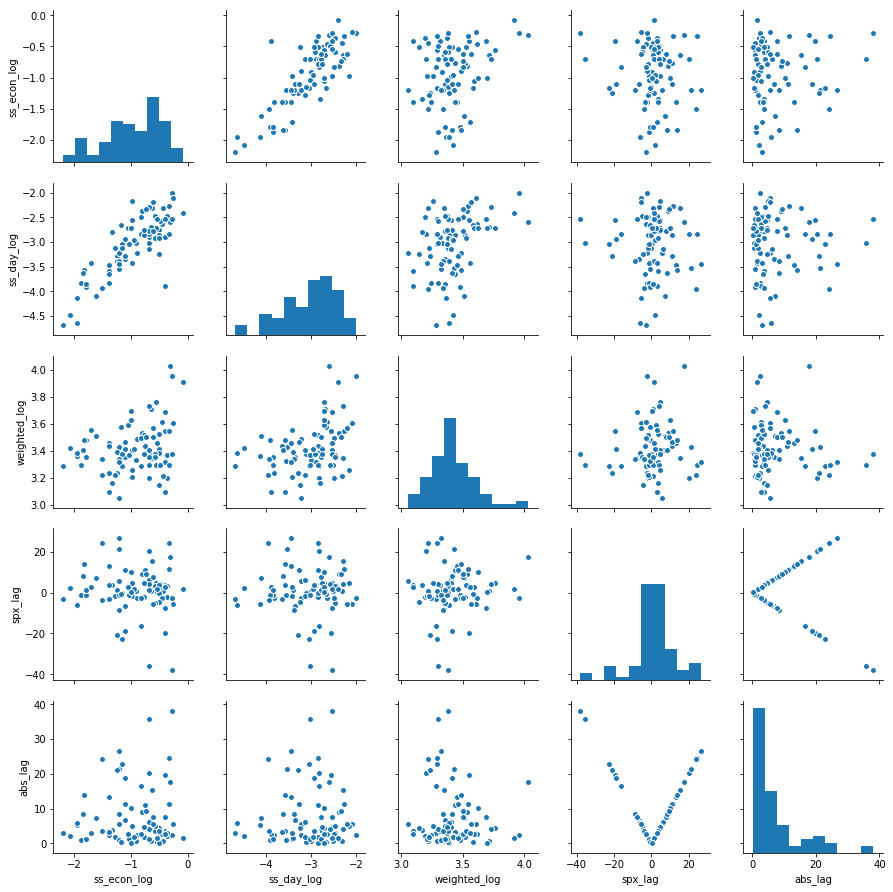

In [29]:
sns.pairplot(feature_set1.loc[:, ['ss_econ_log', 'ss_day_log', 'weighted_log', 'spx_lag', 'abs_lag']]);

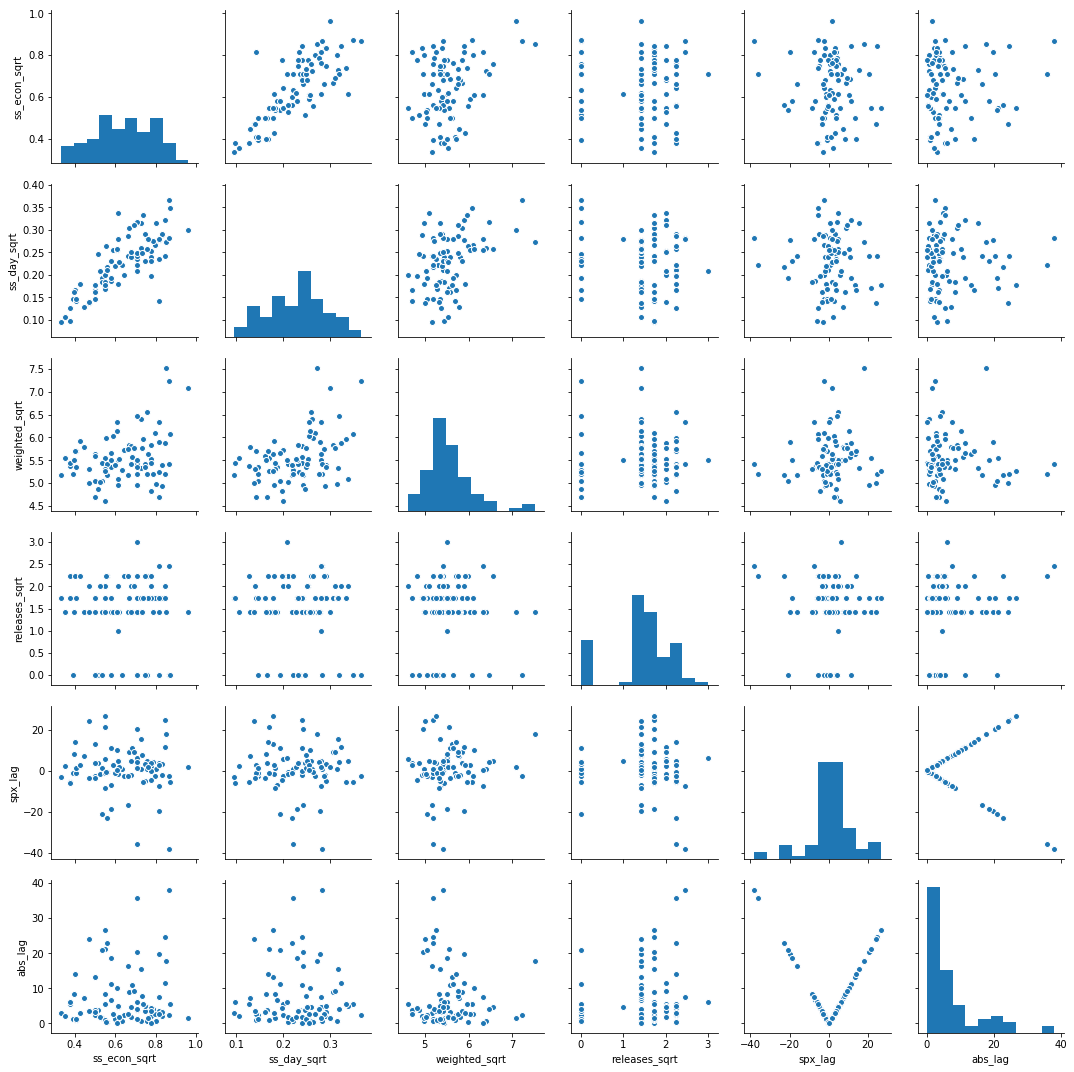

In [30]:
sns.pairplot(feature_set1.loc[:, ['ss_econ_sqrt', 'ss_day_sqrt', 'weighted_sqrt', 'releases_sqrt', 'spx_lag', 'abs_lag']]);

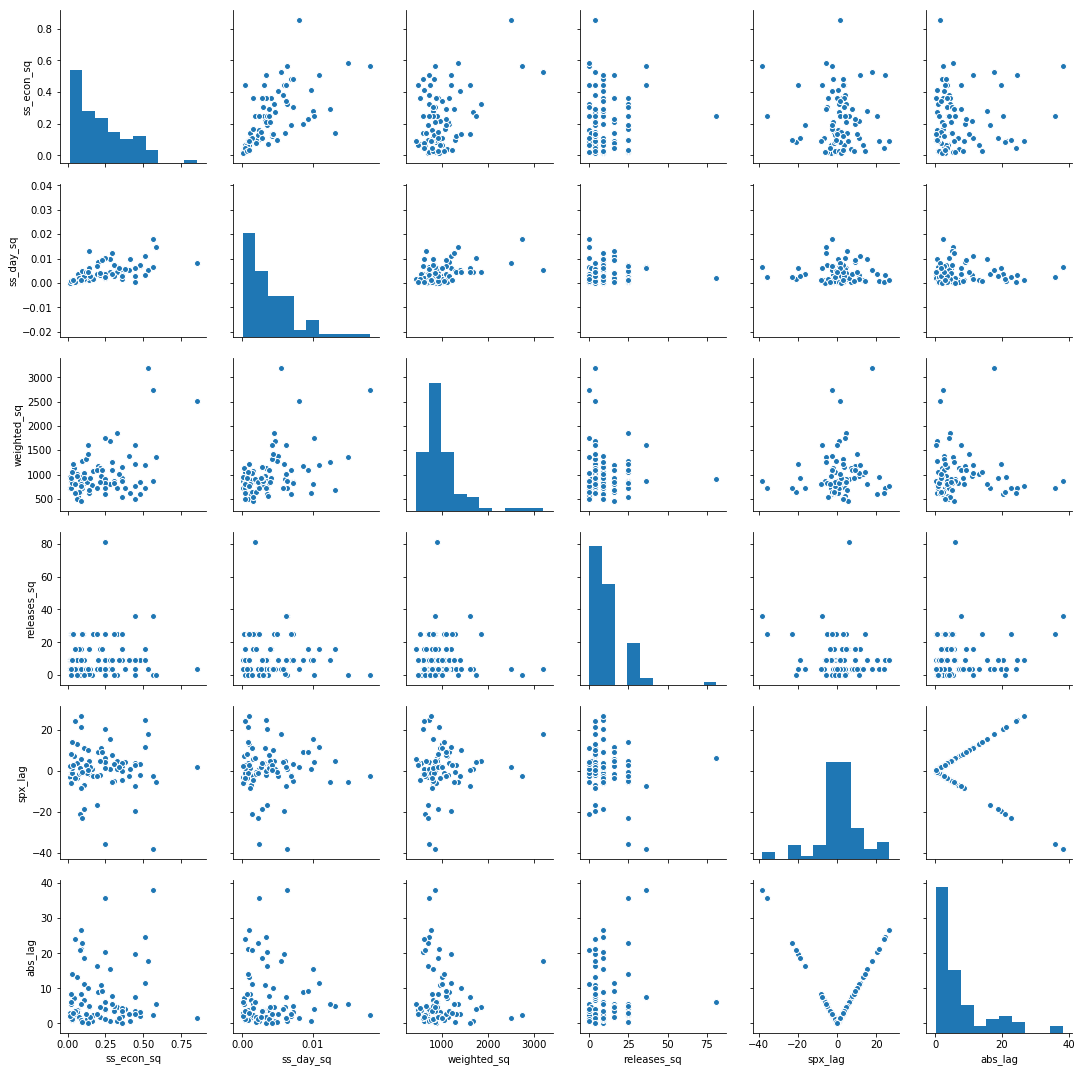

In [31]:
sns.pairplot(feature_set1.loc[:, ['ss_econ_sq', 'ss_day_sq', 'weighted_sq', 'releases_sq', 'spx_lag', 'abs_lag']]);

## Highly experimental process to find which combinations of features and their transformations yield the best regression results

In [ ]:
feature_set1['ss_prod'] = feature_set1['ss_econ'] * feature_set1['ss_day']
feature_set1['sse_rel'] = feature_set1['ss_econ'] * feature_set1['releases']
feature_set1['sse_wei'] = feature_set1['ss_econ'] * feature_set1['weighted']
feature_set1['ssd_rel'] = feature_set1['ss_day'] * feature_set1['releases']
feature_set1['ssd_wei'] = feature_set1['ss_day'] * feature_set1['weighted']
feature_set1['rel_wei'] = feature_set1['releases'] / feature_set1['weighted']

sse = ['ss_econ', 'ss_econ_sq', 'ss_econ_sqrt']
ssd = ['ss_day', 'ss_day_sq', 'ss_day_sqrt']
rel = ['releases', 'releases_sq', 'releases_sqrt']
wei = ['weighted', 'weighted_sq', 'weighted_sqrt']
prod = ['ss_prod', 'sse_rel', 'sse_wei', 'ssd_rel', 'ssd_wei', 'rel_wei']

coeffs = []
mse = []
intercepts = []
alpha = []
score = []
for comb in itertools.product(ssd, sse, rel, wei):
    X = np.array(shuffle.loc[:, list(comb)])
    y = np.array(shuffle.loc[:, ['spx_lag']])
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=.2)
    
    ss = StandardScaler()
    ss.fit(X_train)
    X_train_std = ss.transform(X_train)
    X_test_std = ss.transform(X_test)


    #ssX = StandardScaler()
    #ssX.fit(X)
    #X_std = ss.transform(X)
    
    model = Lasso(max_iter=5000)
    parameters = {'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1], 'fit_intercept': [True, False]}
    grid = GridSearchCV(model, parameters, cv=5, scoring=make_scorer(mean_squared_error), n_jobs=1)
    grid.fit(X_train_std, Y_train)
    
    coeffs.append(grid.best_estimator_.coef_)
    intercepts.append(grid.best_estimator_.intercept_ )
    alpha.append(grid.best_estimator_.alpha)
    
    best_lasso = grid.best_estimator_
    lasso_pred = best_lasso.predict(X_test_std)
    resid = 0
    for true, pred in zip(Y_test, lasso_pred):
        resid += (true - pred)**2
        
    
    mse.append(resid / len(lasso_pred))
    
for a,b,c,d,e in zip(itertools.product(sse, ssd, rel, wei), mse, coeffs, intercepts, alpha):
    if y < 50:
        print(a,b,c,d,e)